In [105]:
import json
import pandas as pd
from augur.utils import json_to_tree
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact

In [106]:
tree_file = '../../../../nextstrain-build/phylogenetic_only_camels/auspice/mers.json'
with open(tree_file, 'r') as f:
    tree_json = json.load(f)
tree = json_to_tree(tree_json)
african_countries = ["Ethiopia", "Kenya", "Egypt", "Nigeria", "Burkina Faso", "Morocco", "Tunisia"]
muts_on_branch = {}


In [107]:
# iterate through terminal branches on the tree to find what mutations are there
for terminal in tree.find_clades(terminal=True): 
    country = terminal.node_attrs.get('country', {})
    country_value = country.get('value', {})
    # Ensure the node is initialized in the dictionary
    muts_on_branch[terminal.name] = {'country': country_value, 'mutations': []}
    
    # Get the mutations on this node from the 'branch_attrs'
    muts = terminal.branch_attrs.get('mutations', {})
    for gene, mutations in muts.items():
        if gene != 'nuc':
            continue
        for m in mutations:
            if str(13410) <= m[1:-1] <= str(16207):
                muts_on_branch[terminal.name]['mutations'].append(m)

print(muts_on_branch)


{'KJ477102': {'country': 'Egypt', 'mutations': ['T13609C', 'G13663A', 'A14356G', 'C14410T', 'C15607T', 'C15706T']}, 'OP712624': {'country': 'Egypt', 'mutations': []}, 'OP712625': {'country': 'Egypt', 'mutations': []}, 'KJ477103': {'country': 'Egypt', 'mutations': []}, 'OP906306': {'country': 'Egypt', 'mutations': []}, 'MK967708': {'country': 'Egypt', 'mutations': []}, 'OP654178': {'country': 'Egypt', 'mutations': []}, 'OP654179': {'country': 'Egypt', 'mutations': ['C14395T']}, 'OP712623': {'country': 'Egypt', 'mutations': []}, 'MG923469': {'country': 'Morocco', 'mutations': ['G13739T', 'T14573C', 'G15535T']}, 'MG923471': {'country': 'Burkina Faso', 'mutations': []}, 'MG923470': {'country': 'Burkina Faso', 'mutations': []}, 'MG923473': {'country': 'Burkina Faso', 'mutations': ['A13689T', 'G13827T', 'C14734T', 'G14911A', 'G14984A']}, 'KU201959': {'country': 'Nigeria', 'mutations': []}, 'KU201953': {'country': 'Nigeria', 'mutations': []}, 'MG923472': {'country': 'Nigeria', 'mutations': []

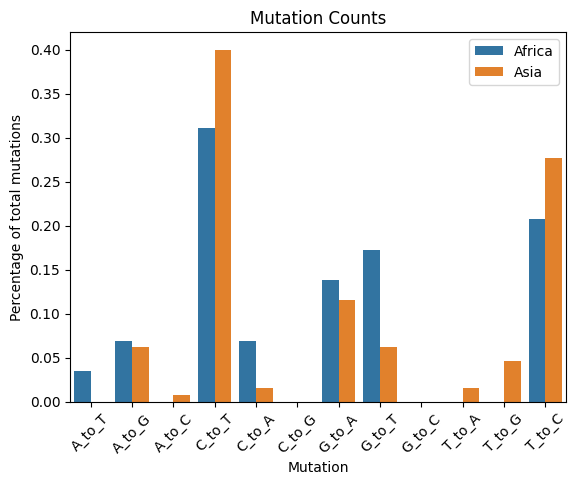

In [108]:
african_samples = 79
asian_samples = 890
african_total = 0
asian_total = 0
mut_counts = {
    'A_to_T': {'Africa': 0, 'Asia': 0}, 'A_to_G': {'Africa': 0, 'Asia': 0}, 'A_to_C': {'Africa': 0, 'Asia': 0},
    'C_to_T': {'Africa': 0, 'Asia': 0}, 'C_to_A': {'Africa': 0, 'Asia': 0}, 'C_to_G': {'Africa': 0, 'Asia': 0},
    'G_to_A': {'Africa': 0, 'Asia': 0}, 'G_to_T': {'Africa': 0, 'Asia': 0}, 'G_to_C': {'Africa': 0, 'Asia': 0},
    'T_to_A': {'Africa': 0, 'Asia': 0}, 'T_to_G': {'Africa': 0, 'Asia': 0}, 'T_to_C': {'Africa': 0, 'Asia': 0}
}

for sample, info in muts_on_branch.items():
    country = info['country']
    nuc = info.get('mutations', [])
    for mut in nuc:
        key = f"{mut[0]}_to_{mut[-1]}"
        if key in mut_counts:
            if country in african_countries:
                african_total += 1
                mut_counts[key]['Africa'] += 1
            else:
                asian_total += 1
                mut_counts[key]['Asia'] += 1

data = []
mutations = []
african_counts = []
asian_counts = []

for mutation, counts in mut_counts.items():
    mutations.append(mutation)
    row_africa = {
        'Mutation': mutation,
        'Count': counts['Africa'] / african_total,
        'Region': 'Africa'
    }
    row_asia = {
        'Mutation': mutation,
        'Count': counts['Asia'] / asian_total,
        'Region': 'Asia'
    }
    data.append(row_africa)
    data.append(row_asia)

    african_counts.append(counts['Africa'])
    asian_counts.append(counts['Asia'])

df = pd.DataFrame(data)

# Create a grouped bar plot
sns.barplot(x='Mutation', y='Count', hue='Region', data=df)

# Customize the plot
plt.title('Mutation Counts')
plt.xlabel('Mutation')
plt.ylabel('Percentage of total mutations')
plt.xticks(rotation=45)
plt.legend()  # Show legend for bar colors

# Show the plot
plt.show()

In [109]:
# Prepare the data
mutation_types = list(mut_counts.keys())
africa_counts = [mut_counts[mut]['Africa'] for mut in mutation_types]
asia_counts = [mut_counts[mut]['Asia'] for mut in mutation_types]

# Combine counts into a contingency table
contingency_table = pd.DataFrame({
    'Mutation': mutation_types,
    'Africa': africa_counts,
    'Asia': asia_counts
}).set_index('Mutation')

# Perform Fisher's Exact Test for each mutation type
p_values = {}
for mutation in contingency_table.index:
    table = [[contingency_table.loc[mutation, 'Africa'], contingency_table.loc[mutation, 'Asia']],
             [african_total - contingency_table.loc[mutation, 'Africa'], asian_total - contingency_table.loc[mutation, 'Asia']]]
    _, p = fisher_exact(table, alternative='two-sided')
    p_values[mutation] = p

print(p_values)

{'A_to_T': 0.18238993710691825, 'A_to_G': 1.0, 'A_to_C': 1.0, 'C_to_T': 0.4062149920483832, 'C_to_A': 0.1522440553791764, 'C_to_G': 1.0, 'G_to_A': 0.7532435485509807, 'G_to_T': 0.06299843754475747, 'G_to_C': 1.0, 'T_to_A': 1.0, 'T_to_G': 0.5930550480236567, 'T_to_C': 0.49478266938820514}


In [110]:
# Filter out mutation types with zero counts in either region
filtered_mut_counts = {
    mutation: counts for mutation, counts in mut_counts.items() 
    if counts['Africa'] > 0 and counts['Asia'] > 0
}

# Create the contingency table
mutation_types = list(filtered_mut_counts.keys())
africa_counts = [filtered_mut_counts[mut]['Africa'] for mut in mutation_types]
asia_counts = [filtered_mut_counts[mut]['Asia'] for mut in mutation_types]

contingency_table = pd.DataFrame({
    'Mutation': mutation_types,
    'Africa': africa_counts,
    'Asia': asia_counts
}).set_index('Mutation')

print(contingency_table)

# Perform Chi-Square Test
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(f"Chi2 Statistic: {chi2}")
print(f"P-value: {p}")

          Africa  Asia
Mutation              
A_to_G         2     8
C_to_T         9    52
C_to_A         2     2
G_to_A         4    15
G_to_T         5     8
T_to_C         6    36
Chi2 Statistic: 7.132424640339547
P-value: 0.21097655400255666
